In [1]:
!pip install fastjet
!pip install uproot
!pip install torch
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.4/879.4 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import uproot
import awkward as ak
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import add_self_loops
from torch_geometric.data import Data, Batch, Dataset, download_url
from torch_geometric.loader import DataLoader
import itertools
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import os.path as osp
from sklearn.metrics import roc_curve, auc

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_file_1 = '/content/drive/MyDrive/Data_files/fcc_ee_h_ss.root'
data_file_2 = '/content/drive/MyDrive/Data_files/fcc_ee_h_qq.root'
tree_1 = uproot.open(data_file_1)['events']
tree_2 = uproot.open(data_file_2)['events']

Mounted at /content/drive


In [4]:
pid = ak.concatenate([tree_1['Particle.PDG'].array(), tree_2['Particle.PDG'].array()], axis = 0)
p_status = ak.concatenate([tree_1['Particle.generatorStatus'].array(), tree_2['Particle.generatorStatus'].array()], axis = 0)
charge = ak.concatenate([tree_1['Particle.charge'].array(), tree_2['Particle.charge'].array()], axis = 0)
m = ak.concatenate([tree_1['Particle.mass'].array(), tree_2['Particle.mass'].array()], axis = 0)
px = ak.concatenate([tree_1['Particle.momentum.x'].array(), tree_2['Particle.momentum.x'].array()], axis = 0)
py = ak.concatenate([tree_1['Particle.momentum.y'].array(), tree_2['Particle.momentum.y'].array()], axis = 0)
pz = ak.concatenate([tree_1['Particle.momentum.z'].array(), tree_2['Particle.momentum.z'].array()], axis = 0)
p_begin = ak.concatenate([tree_1['Particle.parents_begin'].array(), tree_2['Particle.parents_begin'].array()], axis = 0)
p_end = ak.concatenate([tree_1['Particle.parents_end'].array(), tree_2['Particle.parents_end'].array()], axis = 0)
p_ind = ak.concatenate([tree_1['Particle#0.index'].array(), tree_2['Particle#0.index'].array()], axis = 0)

In [5]:
# Function to calculate energy
def energy(m, px, py, pz):
    E = np.sqrt( m**2 + px**2 + py**2 + pz**2)
    return E

In [6]:
e = energy(m, px, py, pz) # Energy of particles

In [7]:
def get_parent_indx(i, particle_ids, parent_indices, parents_begin, parents_end):
      """
      Find parent ID and it's index in the particle IDs list.

      Parameters:
          i (integer): Index of the stable particle.
          particle_ids (list): A list of particle IDs.
          parent_indices (list): A list of parent indices of particles.
          parents_begin (list): A list of indices of the first parent of each particle.
          parents_end (list): A list of indices of the last parent of each particle.

      Returns:
          parent_indx (integer): Index of the parent particle.
      """
      pb = int(parents_begin[i])
      pe = int(parents_end[i])

      parent_ind = []

      if pb == pe :
          parent_ind.append(-999)
          return parent_ind
      else :
          for ind in range(pb, pe):
              indx = int(parent_indices[ind])  # Access parent_indices using ind
              parent_ind.append(int(indx))
          return parent_ind

In [8]:
def find_repeated_lists(list_of_lists):
        """
        Find indices of lists that appear twice or more in the given list of lists.

        Parameters:
            list_of_lists (list of lists): The input list of lists.

        Returns:
            dict: A dictionary where keys are the repeated lists (as tuples) and values are lists of their indices.
        """
        seen = defaultdict(list)  # Dictionary to store indices of each list (as tuple)

        # Store indices of each unique list
        for idx, sublist in enumerate(list_of_lists):
            seen[tuple(sublist)].append(idx)

        # Filter only repeated lists
        repeated = {k: v for k, v in seen.items() if len(v) > 1}

        return repeated

In [9]:
def get_pd_ids(stable_indx, particle_ids, parent_indices, parents_begin, parents_end):
        """
        Identifies particles with shared parents and groups their IDs.

        This function finds particles that have the same parent indices and collects
        their IDs along with their parent IDs.

        Parameters:
            stable_indx (list): A list of indices of stable particles.
            particle_ids (list): A list of particle IDs.
            parent_ind_list (list of lists): A list where each sublist contains
                                          the parent indices of a particle.

        Returns:
            list of lists: A list where each sublist contains the parent IDs and
                          the IDs of particles sharing those parents.
                          Format: [[parent_id1, parent_id2, ..., [daughter_id1, daughter_id2, ...]], ...]
        """
        parent_ind_list = []
        for i in stable_indx :
            parent_ind_list.append(get_parent_indx(i, particle_ids, parent_indices, parents_begin, parents_end))

        pd_id_list = []  # Initialize the list to store parent-daughter ID groups

        sparent_indx = [] # This list contains index of Ks meson, lambda baryon and lambdabar baryon.

        # Find repeated parent index lists and their indices
        result = find_repeated_lists(parent_ind_list)

        # Iterate through the repeated parent index lists
        for key, indices in result.items():
            parents = []  # List to store parent IDs for the current group
            daughters = []  # List to store daughter IDs for the current group
            parent_list = list(key)  # Convert the tuple key to a list, a list with parent index

            # Get parent IDs using parent indices
            for ind_1 in parent_list :
                if int(particle_ids[ind_1]) == 310 or int(particle_ids[ind_1]) == 3122 or int(particle_ids[ind_1]) == -3122 :
                  sparent_indx.append(ind_1)
                  parents.append(int(particle_ids[ind_1]))
                  for ind_2 in indices :
                    daughters.append(int(particle_ids[stable_indx[ind_2]])) # Get daughter IDs using the indices where the parent list appears
                  j = get_parent_indx(ind_1, particle_ids, parent_indices, parents_begin, parents_end)
                  while j[0] != -999 :
                    parents.append(int(particle_ids[j[0]]))
                    k = get_parent_indx(j[0], particle_ids, parent_indices, parents_begin, parents_end)
                    j[0] = k[0]

                  # Combine parent and daughter IDs for the current group
                  parents.append(daughters)
                  pd_id_list.append(parents)  # Add the group to the main list

        return pd_id_list, sparent_indx  # Return the list of parent-daughter ID groups and special parent indices

In [10]:
def contains_any_group(lst):
        groups = [
            {310, 3, frozenset([211, -211])},
            {310, -3, frozenset([211, -211])},
            {310, 3, frozenset([111, 111])},
            {310, -3, frozenset([111, 111])},
            {3122, 3, frozenset([2212, -211])},
            {3122, -3, frozenset([2212, -211])},
            {3122, 3, frozenset([2112, 111])},
            {3122, -3, frozenset([2112, 111])},
            {-3122, 3, frozenset([-2212, 211])},
            {-3122, -3, frozenset([-2212, 211])},
            {-3122, 3, frozenset([-2112, 111])},
            {-3122, -3, frozenset([-2112, 111])}
        ]

        # Convert input list to a set, ensuring lists are stored as frozen sets
        lst_as_set = {frozenset(x) if isinstance(x, list) else x for x in lst}

        return any(group.issubset(lst_as_set) for group in groups)

In [11]:
def get_graph_list(R) : # R is the radius parameter
  graph_list = [] # List of graph datasets

  N = 200000 # number of events

  deta_mean = -0.0015069327248682111 # Mean of dijet eta distributions
  dpt_mean = 35.78125547420067 # Mean of dijet pt distributions
  dN_mean = 43.16249 # Mean of dijet N distributions

  deta_std = 1.1429906944033923 # Standard deviation of dijet eta distributions
  dpt_std = 17.15648916096553 # Standard deviation of dijet pt distributions
  dN_std = 12.49922825617246 # Standard deviation of dijet N distributions

  device = "cuda" if torch.cuda.is_available() else "cpu"

  for n in range(N) :
      particles_list = [] # A list of all the particles in an event

      constituent_indx = [] # A list of indices of constitents of the dijet

      parent_indices = [] # A list of parent indices of constitents of the dijet

      pt_norm = [] # A list of normalized transverse momentum of the constituents of the dijet

      ident = [] # A list containing identity of the particles

      node_ft = [] # Node feature matrix

      edge_ft = [] # Edge attribute matrix

      photon_energy = 0 # Total photon energy
      muon_energy = 0 # Total muon energy
      electron_energy = 0 # Total electron energy
      Ks_energy = 0 # Total reconstructed Ks meson energy
      lambda_energy = 0 # Total reconstructed lambda baryon energy
      lambdabar_energy = 0 # Total reconstructed lambdabar baryon energy

      sts = p_status[n] # Generator status of particles
      p_x = px[n] # X-momentum of particles
      p_y = py[n] # Y-momentum of particles
      p_z = pz[n] # Z-momentum of particles
      E = e[n] # Energy of particles
      pcharge = charge[n] # Charge of particles
      ids = pid[n] # PDG id of particles
      pinds = p_ind[n] # Parent indices of particles
      pbegin = p_begin[n] # Parent begin indices of particles
      pend = p_end[n] # Parent end indices of particles

      for i in range(len(p_x)) :
        part_p4 = PseudoJet(float(p_x[i]), float(p_y[i]), float(p_z[i]), float(E[i]))
        part_p4.set_user_index(i) # setting the index of the particle
        particles_list.append(part_p4)

      stable_p4 = [] # A list of stable particles in the event

      for i in range(len(particles_list)) :
        if sts[i] == 1 :
          stable_p4.append(particles_list[i])

      # Applying clustering of particles with anti-kt algorithm
      cluster = ClusterSequence(stable_p4, JetDefinition(antikt_algorithm, R))
      jet_set = sorted_by_pt(cluster.inclusive_jets())

      if len(jet_set) > 1 :
        # Dijet kinematics
        dijet = jet_set[0] + jet_set[1]
        d_m = dijet.m() # invariant mass
        d_pt = dijet.pt() # transverse momentum
        d_eta = dijet.eta() # pseudo rapidity
        d_e = dijet.e() # energy

        Dijet_constituents = jet_set[0].constituents() + jet_set[1].constituents() # Dijet constituents

        N_constituents = len(Dijet_constituents) # Total number of constituents N in the dijet

        for i in range(N_constituents) :
          constituent_indx.append(Dijet_constituents[i].user_index())

        for j in constituent_indx :
          const_id = ids[j]

          if const_id == 22 :
            photon_energy += particles_list[j].e()
          if const_id == 13 :
            muon_energy += particles_list[j].e()
          if const_id == 11 :
            electron_energy += particles_list[j].e()

          parent_indx = get_parent_indx(j, ids, pinds, pbegin, pend)

          parent_id = ids[parent_indx[0]]

          pt_norm.append(particles_list[j].pt()/d_pt) # Normalized pT

          p_charge = pcharge[j] # Particle charge

          if p_charge > 0 or parent_id == 3122 :
            ident.append(1)
          elif p_charge < 0 or parent_id == 310 :
            ident.append(-1)
          else :
            ident.append(0)

        pd_list, sparent_indx = get_pd_ids(constituent_indx, ids, pinds, pbegin, pend)

        mes_count = 0 # Number of strange mesons (Ks) in the dijet
        bar_count = 0 # Number of strange baryons (lambda or lambdabar) in the dijet

        for i in range(len(pd_list)) :
          if contains_any_group(pd_list[i]) :
            if pd_list[i][0] == 310 :
              mes_count = 1
              Ks_ind = sparent_indx[i]
              Ks_energy += particles_list[Ks_ind].e()
            if pd_list[i][0] == 3122 :
              bar_count = 1
              lambda_ind = sparent_indx[i]
              lambda_energy += particles_list[lambda_ind].e()
            if pd_list[i][0] == -3122 :
              bar_count = 1
              lambdabar_ind = sparent_indx[i]
              lambdabar_energy += particles_list[lambdabar_ind].e()

        for l in range(len(constituent_indx)) :
          node_ft.append([(d_eta - deta_mean)/deta_std, (d_pt - dpt_mean)/dpt_std, (N_constituents - dN_mean)/dN_std, photon_energy/d_e, muon_energy/d_e, electron_energy/d_e, Ks_energy/d_e, lambda_energy/d_e, lambdabar_energy/d_e, pt_norm[l], ident[l]])

        x = torch.tensor(node_ft, dtype = torch.float).to(device) # Node features matrix

        y = torch.tensor([mes_count, bar_count]).to(device) # Target features

        edge_index = torch.tensor(list(itertools.permutations(range(N_constituents), 2))).T.to(device) # Edge index

        src = edge_index[0].tolist()
        dst = edge_index[1].tolist()

        for i in range(len(src)) :
          node_i = src[i]
          node_j = dst[i]

          edge_ft.append([(d_eta - deta_mean)/deta_std, (d_pt - dpt_mean)/dpt_std, (N_constituents - dN_mean)/dN_std, photon_energy/d_e, muon_energy/d_e, electron_energy/d_e, Ks_energy/d_e, lambda_energy/d_e, lambdabar_energy/d_e, pt_norm[node_i], ident[node_i], pt_norm[node_j], ident[node_j]])

        edge_attr = torch.tensor(edge_ft, dtype = torch.float).to(device) # Edge attributes matrix

        graph_data = Data(x = x, edge_index = edge_index, edge_attr = edge_attr, y = y) # Graph data

        graph_list.append(graph_data)

  return graph_list


In [12]:
graph_data = get_graph_list(0.8)

In [13]:
len(graph_data)

200000

In [14]:
from sklearn.model_selection import train_test_split

# Separate signal and background
signal_graphs = graph_data[:100000]  # First 100K are H → s s̄
background_graphs = graph_data[100000:]  # Next 100K are H → q q̄

# Train-validation-test split (70-15-15)
train_signal, temp_signal = train_test_split(signal_graphs, test_size = 0.30, random_state = 42)
train_background, temp_background = train_test_split(background_graphs, test_size = 0.30, random_state = 42)

val_signal, test_signal = train_test_split(temp_signal, test_size = 0.50, random_state = 42)
val_background, test_background = train_test_split(temp_background, test_size = 0.50, random_state = 42)

# Merge signal and background in each split
train_data = train_signal + train_background
val_data = val_signal + val_background
test_data = test_signal + test_background

# DataLoader for each split
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False)

print(f"Training set: {len(train_data)} graphs (Balanced: {len(train_signal)} signal, {len(train_background)} background)")
print(f"Validation set: {len(val_data)} graphs (Balanced: {len(val_signal)} signal, {len(val_background)} background)")
print(f"Test set: {len(test_data)} graphs (Balanced: {len(test_signal)} signal, {len(test_background)} background)")

Training set: 140000 graphs (Balanced: 70000 signal, 70000 background)
Validation set: 30000 graphs (Balanced: 15000 signal, 15000 background)
Test set: 30000 graphs (Balanced: 15000 signal, 15000 background)


In [15]:
class MPNN(MessagePassing) :
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr = 'mean')
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.edge_lin = torch.nn.Linear(13, out_channels)
        self.out_layer = torch.nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr) :
        x = self.lin(x)
        return self.propagate(edge_index, x = x, edge_attr = edge_attr)

    def message(self, x_j, edge_attr) :
        return x_j + self.edge_lin(edge_attr)

    def update(self, aggr_out) :
        return self.out_layer(aggr_out)

In [16]:
class GraphMPNN(torch.nn.Module) :
    def __init__(self, in_channels, hidden_channels, out_channels = 2) :  # 2 output neurons for classification
        super().__init__()
        self.mpnn = MPNN(in_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data) :
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.mpnn(x, edge_index, edge_attr)
        x = global_mean_pool(x, batch)
        return self.fc(x)  # No softmax, since BCEWithLogitsLoss expects raw logits

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define model
model = GraphMPNN(in_channels = 11, hidden_channels = 16, out_channels = 2).to(device)

# Optimizer and Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = torch.nn.BCEWithLogitsLoss()  # Multi-label classification loss

def evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed for evaluation
        for batch in data_loader:
            out = model(batch)
            probs = torch.sigmoid(out)  # Convert logits to probabilities
            preds = (probs > 0.5).int()  # Convert probabilities to binary labels (0 or 1)
            correct += (preds == batch.y.view(-1, 2)).sum().item()
            total += batch.y.numel()  # Count total number of labels (in the batch)
    return correct / total

# Training loop with validation
best_val_acc = 0
for epoch in range(50):
    model.train()  # Set the model to training mode
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1, 2).float())
        loss.backward()
        optimizer.step()

    # Evaluate on validation set after each epoch
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Validation Accuracy: {val_acc * 100:.2f}%")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

# Load the best model for final testing
model.load_state_dict(torch.load("best_model.pth", weights_only = True))

# Evaluate on the test set
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        probs = torch.sigmoid(out)
        all_probs.append(probs.cpu())
        all_labels.append(batch.y.view(-1, 2).cpu())

y_true = torch.cat(all_labels).numpy()
y_scores = torch.cat(all_probs).numpy()

Epoch 1, Loss: 0.0113, Validation Accuracy: 99.66%
Epoch 2, Loss: 0.0052, Validation Accuracy: 99.57%
Epoch 3, Loss: 0.0002, Validation Accuracy: 99.87%
Epoch 4, Loss: 0.1396, Validation Accuracy: 99.79%
Epoch 5, Loss: 0.0008, Validation Accuracy: 99.91%
Epoch 6, Loss: 0.0009, Validation Accuracy: 99.94%
Epoch 7, Loss: 0.0002, Validation Accuracy: 99.78%
Epoch 8, Loss: 0.0001, Validation Accuracy: 99.95%
Epoch 9, Loss: 0.0013, Validation Accuracy: 99.95%
Epoch 10, Loss: 0.0005, Validation Accuracy: 99.93%
Epoch 11, Loss: 0.0001, Validation Accuracy: 99.98%
Epoch 12, Loss: 0.0000, Validation Accuracy: 99.98%
Epoch 13, Loss: 0.0001, Validation Accuracy: 99.95%
Epoch 14, Loss: 0.0002, Validation Accuracy: 99.98%
Epoch 15, Loss: 0.0000, Validation Accuracy: 99.98%
Epoch 16, Loss: 0.0001, Validation Accuracy: 99.97%
Epoch 17, Loss: 0.0000, Validation Accuracy: 99.96%
Epoch 18, Loss: 0.0000, Validation Accuracy: 99.96%
Epoch 19, Loss: 0.0001, Validation Accuracy: 99.86%
Epoch 20, Loss: 0.000

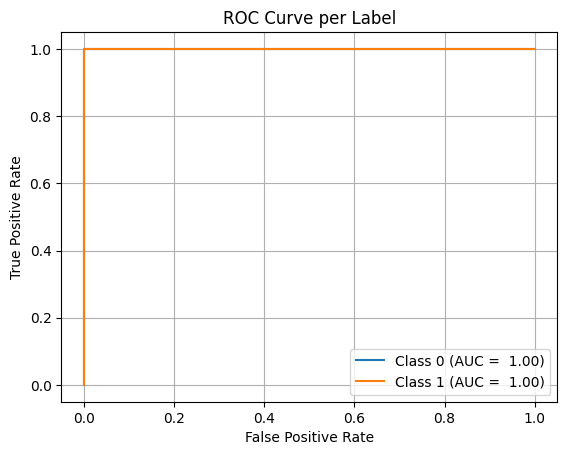

In [22]:
plt.figure()
for i in range(2):  # Two labels
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'Class {i} (AUC = {roc_auc : .2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Label')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()